In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
from bitlinear158 import BitLinear158, BitLinear158Inference

In [2]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
n_data = train_dataset.data.shape[0]

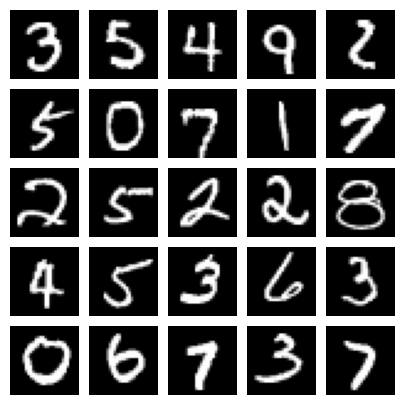

In [4]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [5]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            BitLinear158(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            BitLinear158(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = BitLinear158(latent_dim, 2)
        self.logvar_layer = BitLinear158(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            BitLinear158(2, latent_dim),
            nn.LeakyReLU(0.2),
            BitLinear158(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            BitLinear158(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [6]:
device

device(type='cpu')

In [7]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [8]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [9]:
x_dim = 784

In [10]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/n_data)
    return overall_loss

train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  189.68369938151042
	Epoch 2 	Average Loss:  163.06100078125
	Epoch 3 	Average Loss:  157.7699818684896
	Epoch 4 	Average Loss:  155.26659301757812
	Epoch 5 	Average Loss:  153.676380859375
	Epoch 6 	Average Loss:  152.52420180664063
	Epoch 7 	Average Loss:  151.51574541015626
	Epoch 8 	Average Loss:  150.63179544270832
	Epoch 9 	Average Loss:  149.8533615234375
	Epoch 10 	Average Loss:  149.04183427734375
	Epoch 11 	Average Loss:  148.31955818684895
	Epoch 12 	Average Loss:  148.1015717936198
	Epoch 13 	Average Loss:  147.66288072916666
	Epoch 14 	Average Loss:  147.27966578776042
	Epoch 15 	Average Loss:  147.2052436360677
	Epoch 16 	Average Loss:  147.07790678710938
	Epoch 17 	Average Loss:  146.85089890950522
	Epoch 18 	Average Loss:  146.55045559895834
	Epoch 19 	Average Loss:  146.48383813476562
	Epoch 20 	Average Loss:  146.59806276041667
	Epoch 21 	Average Loss:  146.53141918945312
	Epoch 22 	Average Loss:  146.47138678385417
	Epoch 23 	Average Loss:  14

8761832.243164062

In [11]:
def change_to_inference(model):
    
    bitlinear_layers  = [(k, m) for k, m in model.named_modules() if type(m).__name__ == 'BitLinear158'] 
    for name, layer in bitlinear_layers:
        layer.beta = 1 / layer.weight.abs().mean().clamp(min=1e-5)
        layer.weight = nn.Parameter((layer.weight * layer.beta).round().clamp(-1, 1))
        layer.weight.detach()
        layer.weight.requires_grad = False
        new_layer = BitLinear158Inference(layer.input_dim, layer.output_dim)  
        new_layer.weight.data = layer.weight.data.clone()
        setattr(model, name, new_layer)

change_to_inference(model)
change_to_inference(model.decoder)

# TODO Problem here has to be recursive 


In [12]:
print(model)

VAE(
  (encoder): Sequential(
    (0): BitLinear158(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): BitLinear158(in_features=400, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (mean_layer): BitLinear158Inference(in_features=200, out_features=2, bias=True)
  (logvar_layer): BitLinear158Inference(in_features=200, out_features=2, bias=True)
  (decoder): Sequential(
    (0): BitLinear158Inference(in_features=2, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): BitLinear158Inference(in_features=200, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): BitLinear158Inference(in_features=400, out_features=784, bias=True)
    (5): Sigmoid()
  )
  (encoder.0): BitLinear158Inference(in_features=784, out_features=400, bias=True)
  (encoder.2): BitLinear158Inference(in_features=400, out_features=200, bias=True)
  (decoder.0): BitLinear158Inference(in_features=2, out_features=

In [13]:
print(model.decoder)

Sequential(
  (0): BitLinear158Inference(in_features=2, out_features=200, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): BitLinear158Inference(in_features=200, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): BitLinear158Inference(in_features=400, out_features=784, bias=True)
  (5): Sigmoid()
)


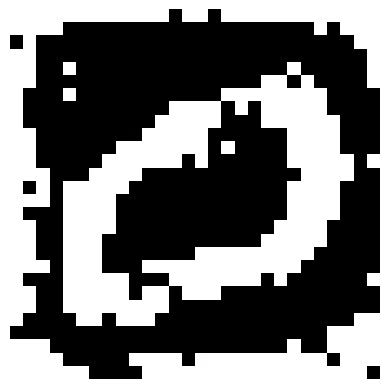

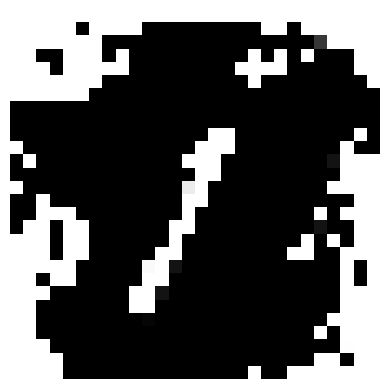

(None, None)

In [22]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(20.8, 37.5), generate_digit(-8.3, 0)

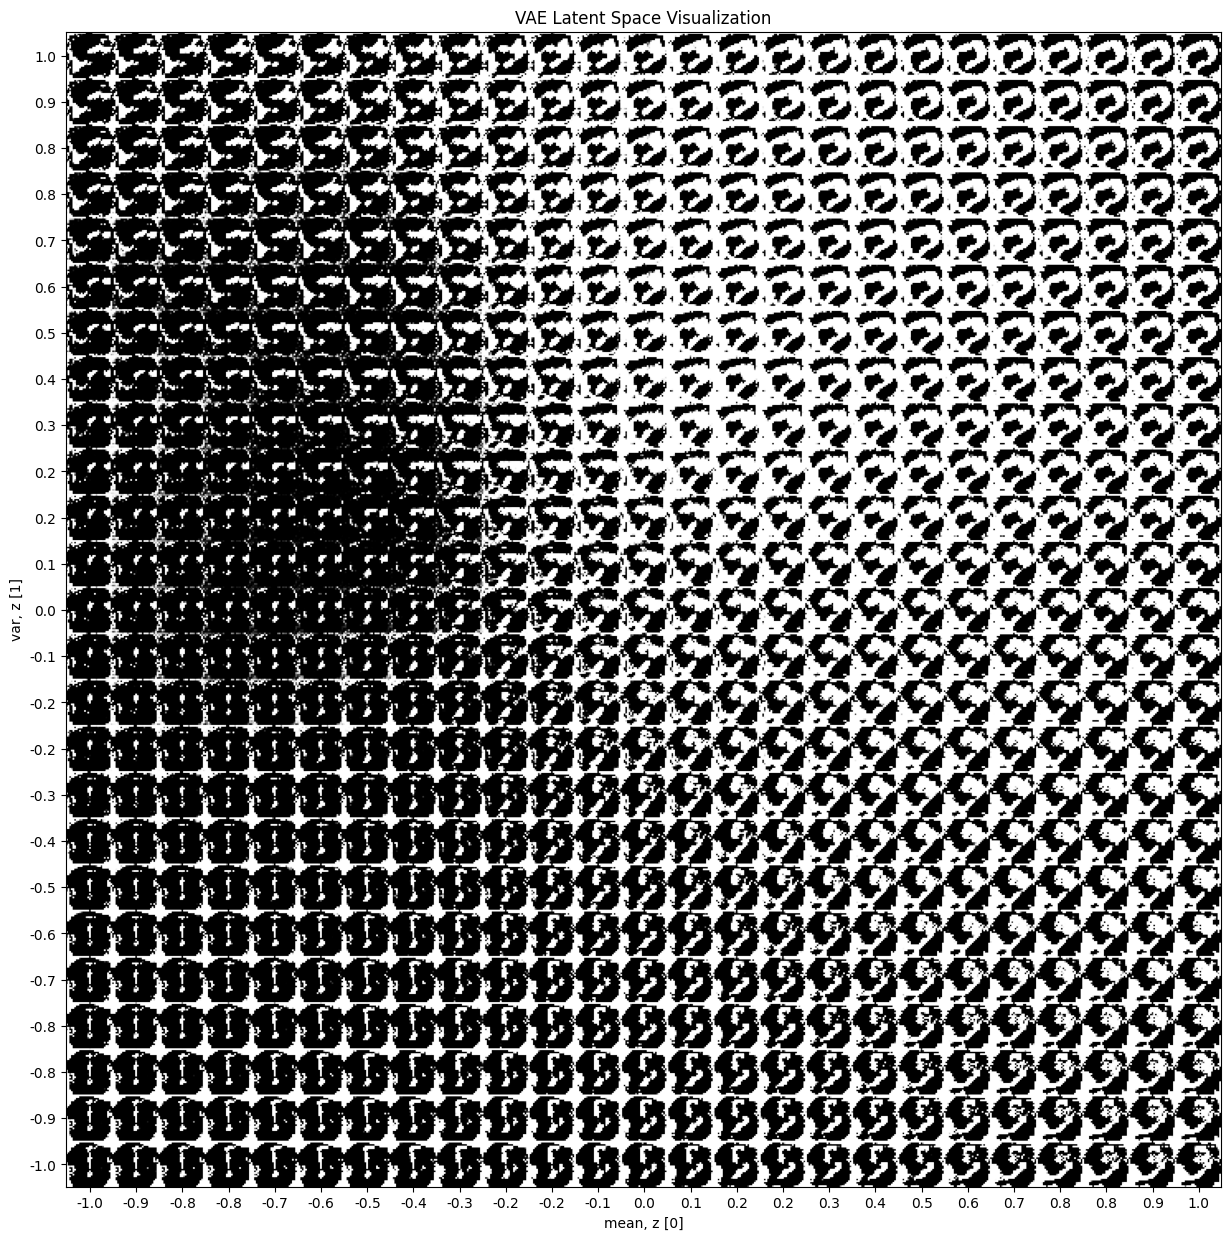

In [15]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

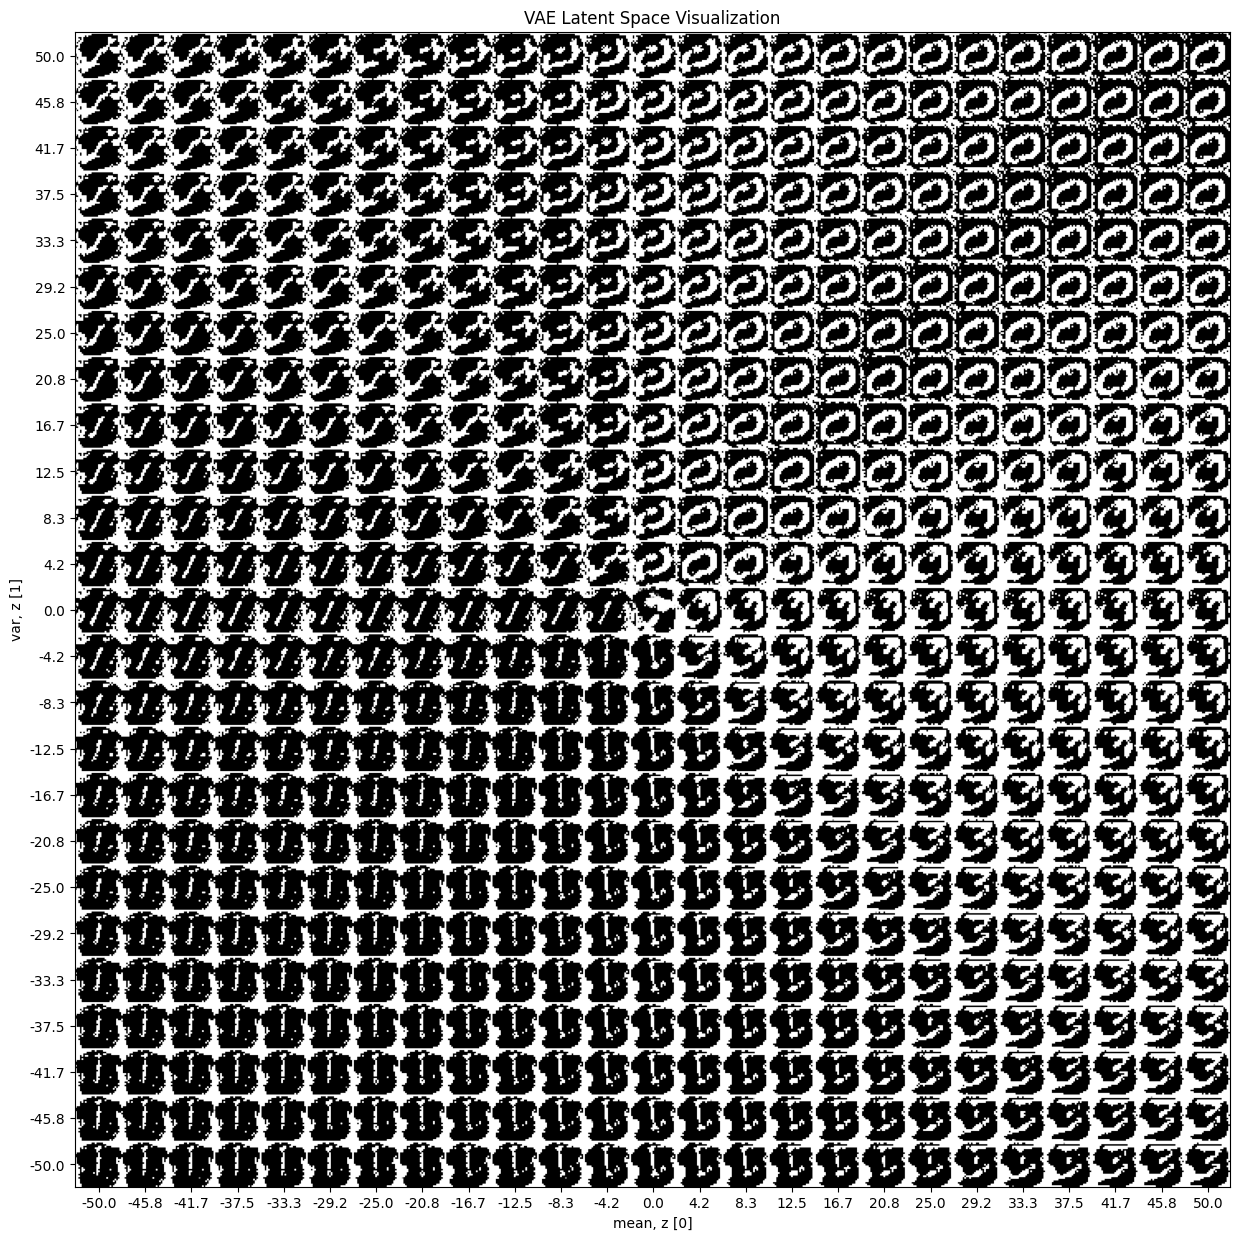

In [20]:
plot_latent_space(model, scale=50)